In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random

In [77]:
def fix_seeds(seed=42, deterministic=True):
    """
    Fix all random seeds for reproducibility.

    Args:
        seed (int): The seed value to use.
        deterministic (bool): If True, forces deterministic behavior in cuDNN (may reduce performance).
    """
    # Python's built-in random module
    random.seed(seed)

    # NumPy random generator
    np.random.seed(seed)

    # PyTorch seed for CPU & CUDA
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If using multi-GPU

    # Ensuring deterministic behavior (if desired)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False  # Might slow down training but ensures reproducibility
fix_seeds()

In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [79]:
data = pd.read_csv("collocation_points.csv")
collocation_points = torch.tensor(data.values, dtype=torch.float32, requires_grad=True).to(device)

In [80]:
beta = 70.0
L = 2* np.pi
lamda = 0.1
t_max = 1.0

In [81]:
def pde_residual(collocation_points, model):
    u_pred = model(collocation_points)
    grad_u = torch.autograd.grad(
        u_pred,
        collocation_points,
        grad_outputs=torch.ones_like(u_pred),
        create_graph=True
    )[0]
    u_x = grad_u[:, 0:1]  # derivative with respect to x
    u_t = grad_u[:, 1:2]  # derivative with respect to t

    # PDE residual: (u_t + beta*u_x)^2
    residual = u_t + beta * u_x
    return torch.mean(residual**2)

In [82]:
def periodic_boundary_loss(model):
    
    t_samples = torch.linspace(0, 1, 256, device= device).unsqueeze(1)
    x_left = torch.zeros_like(t_samples)
    x_right = torch.full_like(t_samples, L)

    left_input = torch.cat((x_left, t_samples), dim=1)
    right_input = torch.cat((x_right, t_samples), dim=1)

    u_left = model(left_input)
    u_right = model(right_input)
    # Enforce periodicity: u(0, t) ≈ u(2π, t)
    return torch.mean((u_left - u_right) ** 2)

In [ ]:
def initial_condition_loss(model):
    x_samples = torch.linspace(0, L, 512, device= device).unsqueeze(1)
    t_zero = torch.zeros_like(x_samples)  # t = 0

    init_input = torch.cat((x_samples, t_zero), dim=1)
    u_init_pred = model(init_input)

    # True initial condition: u(x, 0) = sin(x)
    u_init_true = torch.sin(x_samples)

    return torch.mean((u_init_pred - u_init_true) ** 2)

In [84]:
def loss_function(model, collocation_points):
    loss_pde = pde_residual(collocation_points, model)
    loss_pb = periodic_boundary_loss(model)
    loss_ic = initial_condition_loss(model)
    return lamda*loss_pde + loss_pb + loss_ic

In [85]:
class PINN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=50, output_dim=1, num_layers=4):
        """
        Initializes a fully connected neural network with tanh activation.

        Args:
            input_dim (int): Number of input features (x, t).
            hidden_dim (int): Number of neurons per hidden layer.
            output_dim (int): Number of output neurons (u).
            num_layers (int): Number of hidden layers.
        """
        super(PINN, self).__init__()
        
        layers = [nn.Linear(input_dim, hidden_dim), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_dim, output_dim))
        
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [86]:
model = PINN().to(device)

In [87]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
losses = []
def train(model, optimizer, collocation_points, num_epochs=100000):
    pbar = tqdm(range(num_epochs), desc="Training Epoch")
    for epoch in pbar:
        optimizer.zero_grad()
        loss = loss_function(model, collocation_points)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        pbar.set_postfix(loss=loss.item())

train(model, optimizer, collocation_points)
print("Training completed")

Training Epoch: 100%|██████████| 100000/100000 [08:20<00:00, 199.95it/s, loss=0.000397]

Training completed


In [88]:
print(collocation_points[1][1].item())

0.31104376912117004


In [89]:
print(collocation_points[1][1].item())

0.31104376912117004


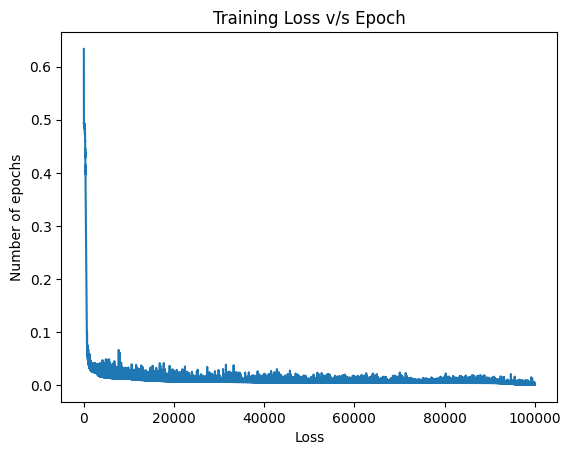

In [90]:
plt.plot(losses)
plt.title("Training Loss v/s Epoch")
plt.xlabel("Loss")
plt.ylabel("Number of epochs")
plt.show()

In [91]:
def exact_solution_fft(x_array, t, h_values, beta, L):
    """
    Computes the exact solution of the 1D convection PDE using the Fourier transform approach.
    Assumes periodic boundary conditions on [0, L).

    Args:
        x_array (np.ndarray): 1D array of x-values (length N) on [0, L), evenly spaced.
        t (float): Time at which to evaluate the solution.
        h_values (np.ndarray): 1D array of h(x_array), same length as x_array.
        beta (float): Convection speed.
        L (float): Domain length for periodic boundary conditions.

    Returns:
        np.ndarray: Real part of the exact solution u(x, t) on the same grid x_array.
    """
    N = len(x_array)
    # Forward FFT of initial condition
    H_k = np.fft.fft(h_values)
    # Wavenumbers k: 2π * (integer) / L
    k_array = 2 * np.pi * np.fft.fftfreq(N, d=(L / N))
    # Multiply by e^{- i * beta * k * t}
    phase_factor = np.exp(-1j * beta * k_array * t)
    U_k = H_k * phase_factor
    # Inverse FFT to get solution
    u_vals = np.fft.ifft(U_k)
    return u_vals.real

In [92]:
model.eval()

PINN(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Tanh()
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Tanh()
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [93]:
Nx = 256
Nt = 100
x_vals = np.linspace(0, L, Nx, endpoint=False)
t_vals = np.linspace(0, t_max, Nt)
X, T = np.meshgrid(x_vals, t_vals)

In [94]:
h_values = np.sin(x_vals)
U_exact = np.zeros_like(X)
for i, t_val in enumerate(t_vals):
    U_exact[i, :] = exact_solution_fft(x_vals, t_val, h_values, beta, L)

In [95]:
XT = np.stack([X.ravel(), T.ravel()], axis=1)
XT_tensor = torch.tensor(XT, dtype=torch.float32).to(device)
with torch.no_grad():
    U_pred_tensor = model(XT_tensor)
U_pred = U_pred_tensor.cpu().numpy().reshape(Nt, Nx)

In [96]:
U_diff = U_pred - U_exact

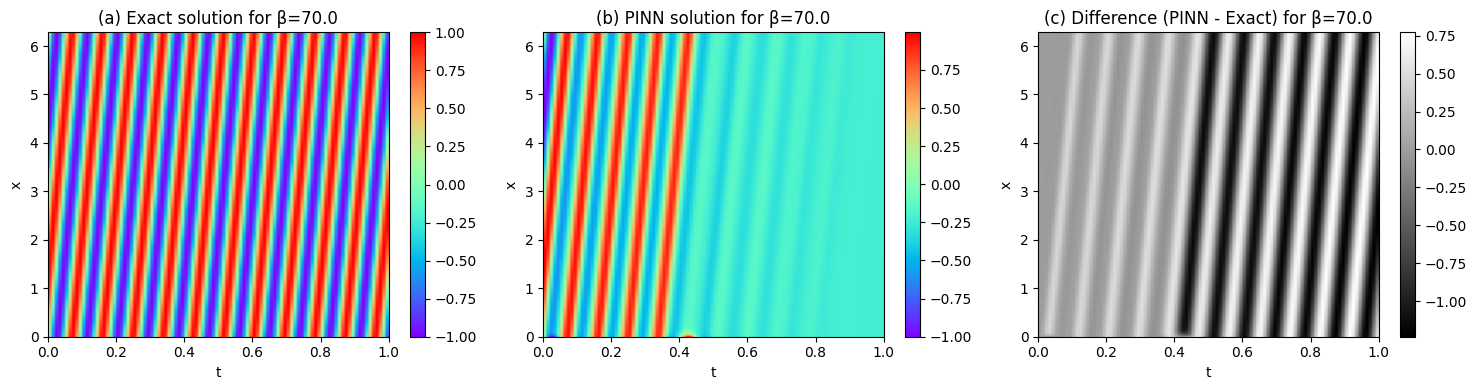

In [97]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# (a) Exact solution
c1 = axes[0].imshow(
  U_exact.T,
  extent=[0, t_max, 0, L],  # x horizontal, t vertical
  origin="lower",
  aspect="auto",
  cmap="rainbow"
)
axes[0].set_title(f"(a) Exact solution for β={beta}")
axes[0].set_xlabel("t")
axes[0].set_ylabel("x")
fig.colorbar(c1, ax=axes[0])

# (b) PINN solution
c2 = axes[1].imshow(
    U_pred.T,
    extent=[0, t_max, 0, L],
    origin="lower",
    aspect='auto',
    cmap='rainbow'
)
axes[1].set_title(f"(b) PINN solution for β={beta}")
axes[1].set_xlabel("t")
axes[1].set_ylabel("x")
fig.colorbar(c2, ax=axes[1])

# (c) Difference
c3 = axes[2].imshow(
    U_diff.T,
    extent=[0, t_max, 0, L],
    origin="lower",
    aspect='auto',
    cmap='gray'
)
axes[2].set_title(f"(c) Difference (PINN - Exact) for β={beta}")
axes[2].set_xlabel("t")
axes[2].set_ylabel("x")
fig.colorbar(c3, ax=axes[2])

plt.tight_layout()
plt.show()
